This notebook gives a demo of merging several fast-BHMs, from W. Zhi, L. Ott, R. Senanayake, F. Ramos, "Continuous Occupancy Map Fusion with Fast Bayesian Hilbert Maps Icra", ICRA, 2019. The code for fast-BHMs is adapted from code written for R. Senanayake, F. Ramos, "Bayesian Hilbert Maps for Dynamic Continuous Occupancy Mapping", CoRL, 2017. 

The dataset into 4 batches. Each batch is then separated into 4 based on the regions of the scans to train 4 sub-maps.

We aim to do the following:
1. Train 4 sub-maps using the data from different regions in batch 1.
2. Merge the 4 sub-maps into one merged map.
3. Distribute the merged map to the 4 agents.
4. Train the 4 sub-maps from the first merged map using the data from different regions in batch 2.
5. Merge and repeat this process until we have trained on all the batches, and have one merge and distribute after training each batch.

In [3]:
#Import Libraries Load Data and Load Weights
import numpy as np
import pandas as pd
import sbhm_noInt_diag as sbhm
import matplotlib.pyplot as pl
import copy
import scipy.sparse
#initialise Parameters
def load_parameters(case):
    parameters = \
        {
         
         'intel': \
             (
              (0.5, 0.5), 
              (-20, 20, -25, 10),
              1,
              0.01,
              6.71
            ),

        }

    return parameters[case]

#Here is data on 4 submaps. These 4 submaps are gathered in 4 different batches
LUX_1_1=np.load("./data/LUX_1_1.npy"); LUX_1_2=np.load("./data/LUX_1_2.npy"); LUX_2_1=np.load("./data/LUX_2_1.npy"); LUX_2_2=np.load("./data/LUX_2_2.npy")
LLX_1_1=np.load("./data/LLX_1_1.npy"); LLX_1_2=np.load("./data/LLX_1_2.npy"); LLX_2_1=np.load("./data/LLX_2_1.npy"); LLX_2_2=np.load("./data/LLX_2_2.npy")

RUX_1_1=np.load("./data/RUX_1_1.npy"); RUX_1_2=np.load("./data/RUX_1_2.npy"); RUX_2_1=np.load("./data/RUX_2_1.npy"); RUX_2_2=np.load("./data/RUX_2_2.npy")
RLX_1_1=np.load("./data/RLX_1_1.npy"); RLX_1_2=np.load("./data/RLX_1_2.npy"); RLX_2_1=np.load("./data/RLX_2_1.npy"); RLX_2_2=np.load("./data/RLX_2_2.npy")

LUY_1_1=np.load("./data/LUY_1_1.npy"); LUY_1_2=np.load("./data/LUY_1_2.npy"); LUY_2_1=np.load("./data/LUY_2_1.npy"); LUY_2_2=np.load("./data/LUY_2_2.npy")
LLY_1_1=np.load("./data/LLY_1_1.npy"); LLY_1_2=np.load("./data/LLY_1_2.npy"); LLY_2_1=np.load("./data/LLY_2_1.npy"); LLY_2_2=np.load("./data/LLY_2_2.npy")

RUY_1_1=np.load("./data/RUY_1_1.npy"); RUY_1_2=np.load("./data/RUY_1_2.npy"); RUY_2_1=np.load("./data/RUY_2_1.npy"); RUY_2_2=np.load("./data/RUY_2_2.npy")
RLY_1_1=np.load("./data/RLY_1_1.npy"); RLY_1_2=np.load("./data/RLY_1_2.npy"); RLY_2_1=np.load("./data/RLY_2_1.npy"); RLY_2_2=np.load("./data/RLY_2_2.npy")


cell_resolution, cell_max_min, skip, thresh, gamma = load_parameters('intel')

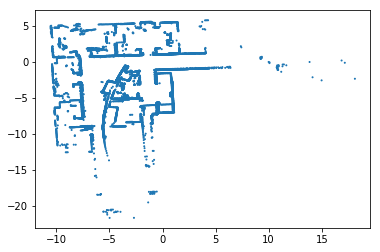

In [4]:
#Let us look at submaps of our first batch of the data
figure = pl.figure(figsize=(8,8))
ax = figure.add_subplot(2,2,1)
ax.scatter(LUX_1_1[:,1],LUX_1_1[:,2], c=LUY_1_1, cmap='jet', s=8, marker='8',edgecolors='')
ax.set_xlim([cell_max_min[0], cell_max_min[1]]); ax.set_ylim([cell_max_min[2], cell_max_min[3]])

ax = figure.add_subplot(2,2,2)
ax.scatter(LLX_1_1[:,1],LLX_1_1[:,2] c=LLY_1_1, cmap='jet', s=8, marker='8',edgecolors='')
ax.set_xlim([cell_max_min[0], cell_max_min[1]]); ax.set_ylim([cell_max_min[2], cell_max_min[3]])

ax = figure.add_subplot(2,2,3)
ax.scatter(RUX_1_1[:,1],RUX_1_1[:,2], c=RUY_1_1, cmap='jet', s=8, marker='8',edgecolors='')
ax.set_xlim([cell_max_min[0], cell_max_min[1]]); ax.set_ylim([cell_max_min[2], cell_max_min[3]])

ax = figure.add_subplot(2,2,4)
queried = bhm_mdl_right_lower_1_1.predict_proba(q_x)[:,1]
ax.scatter(RLX_1_1[:,1],RLX_1_1[:,2], c=RLY_1_1, cmap='jet', s=8, marker='8',edgecolors='')
ax.set_xlim([cell_max_min[0], cell_max_min[1]]); ax.set_ylim([cell_max_min[2], cell_max_min[3]])
pl.show()

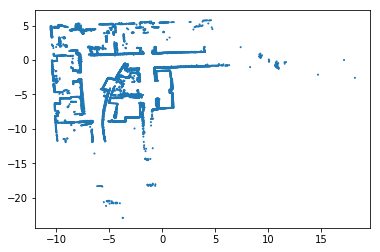

In [8]:
#Let us look at the data from the second batch:
figure = pl.figure(figsize=(8,8))
ax = figure.add_subplot(2,2,1)
ax.scatter(LUX_1_2[:,1],LUX_1_2[:,2], c=LUY_1_2, cmap='jet', s=8, marker='8',edgecolors='')
ax.set_xlim([cell_max_min[0], cell_max_min[1]]); ax.set_ylim([cell_max_min[2], cell_max_min[3]])

ax = figure.add_subplot(2,2,2)
ax.scatter(LLX_1_2[:,1],LLX_1_2[:,2] c=LLY_1_2, cmap='jet', s=8, marker='8',edgecolors='')
ax.set_xlim([cell_max_min[0], cell_max_min[1]]); ax.set_ylim([cell_max_min[2], cell_max_min[3]])

ax = figure.add_subplot(2,2,3)
ax.scatter(RUX_1_2[:,1],RUX_1_2[:,2], c=RUY_1_2, cmap='jet', s=8, marker='8',edgecolors='')
ax.set_xlim([cell_max_min[0], cell_max_min[1]]); ax.set_ylim([cell_max_min[2], cell_max_min[3]])

ax = figure.add_subplot(2,2,4)
ax.scatter(RLX_1_2[:,1],RLX_1_2[:,2], c=RLY_1_2, cmap='jet', s=8, marker='8',edgecolors='')
ax.set_xlim([cell_max_min[0], cell_max_min[1]]); ax.set_ylim([cell_max_min[2], cell_max_min[3]])
pl.show()

In [ ]:
#training model on sub-map. We can repeatedly do this to all the submaps
max_t = len(np.unique(LUX_1_1[:, 0]))
skip=1
start=0
uniqueList=np.unique(LUX_1_1[:,0])
for ith_scan in range(start, max_t, skip): 
    # extract data points of the ith scan
    ith_scan_indx = LUX_1_1[:, 0] == uniqueList[ith_scan]
    X_new = LUX_1_1[ith_scan_indx, 1:]
    y_new = LUY_1_1[ith_scan_indx]    
    if ith_scan == start:
        # get all data for the first scan and initialize the model
        X, y = X_new, y_new
        bhm_mdl_left_upper_1_1 = sbhm.SBHM(gamma=gamma, grid=None, cell_resolution=cell_resolution, cell_max_min=cell_max_min, X=X, calc_loss=False)
    else:
        # information filtering
        q_new = bhm_mdl_left_upper_1_1.predict_proba(X_new)[:, 1]
        info_val_indx = np.absolute(q_new - y_new) > thresh
        X, y = X_new[info_val_indx, :], y_new[info_val_indx]
        X = X
        y = y   
    if(X.shape[0]>0):
        bhm_mdl_left_upper_1_1.fit(X, y)

In [12]:
#or we can load our pre-trained models, trained on the first batch of partitioned data
bhm_mdl_left_upper_1_1 = sbhm.SBHM(gamma=gamma, grid=None, cell_resolution=cell_resolution, cell_max_min=cell_max_min, X=np.array, calc_loss=False, fresh=False)
bhm_mdl_left_upper_1_1.coef_ = np.load("LU11_coef.npy")
bhm_mdl_left_upper_1_1.sigma_ = np.array([scipy.sparse.load_npz('LU11_sigma.npz').todense()])

bhm_mdl_right_upper_1_1 = sbhm.SBHM(gamma=gamma, grid=None, cell_resolution=cell_resolution, cell_max_min=cell_max_min, X=np.array, calc_loss=False, fresh=False)
bhm_mdl_right_upper_1_1.coef_ = np.load("RU11_coef.npy")
bhm_mdl_right_upper_1_1.sigma_ = np.array([scipy.sparse.load_npz('RU11_sigma.npz').todense()])

bhm_mdl_left_lower_1_1 = sbhm.SBHM(gamma=gamma, grid=None, cell_resolution=cell_resolution, cell_max_min=cell_max_min, X=np.array, calc_loss=False, fresh=False)
bhm_mdl_left_lower_1_1.coef_ = np.load("LL11_coef.npy")
bhm_mdl_left_lower_1_1.sigma_ = np.array([scipy.sparse.load_npz('LL11_sigma.npz').todense()])

bhm_mdl_right_lower_1_1 = sbhm.SBHM(gamma=gamma, grid=None, cell_resolution=cell_resolution, cell_max_min=cell_max_min, X=np.array, calc_loss=False, fresh=False)
bhm_mdl_right_lower_1_1.coef_ = np.load("RL11_coef.npy")
bhm_mdl_right_lower_1_1.sigma_ = np.array([scipy.sparse.load_npz('RL11_sigma.npz').todense()])


D= 5600
D= 5600
D= 5600
D= 5600


In [13]:
#Query Grid
q_resolution = 0.2
xx, yy = np.meshgrid(np.arange(cell_max_min[0], cell_max_min[1]-1, q_resolution), np.arange(cell_max_min[2], cell_max_min[3]-1, q_resolution))
q_x = np.hstack((xx.ravel()[:, np.newaxis], yy.ravel()[:, np.newaxis]))
queried = bhm_mdl_left_upper_1_1.predict_proba(q_x)[:,1]

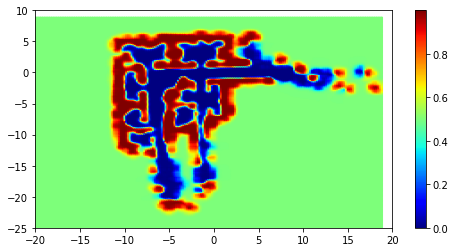

In [14]:
#Plot Submaps
figure = pl.figure(figsize=(8,8))
ax = figure.add_subplot(2,2,1)
ax.scatter(q_x[:, 0], q_x[:, 1], c=queried, cmap='jet', s=8, marker='8',edgecolors='')
ax.set_xlim([cell_max_min[0], cell_max_min[1]]); ax.set_ylim([cell_max_min[2], cell_max_min[3]])

ax = figure.add_subplot(2,2,2)
queried = bhm_mdl_right_upper_1_1.predict_proba(q_x)[:,1]
ax.scatter(q_x[:, 0], q_x[:, 1], c=queried, cmap='jet', s=8, marker='8',edgecolors='')
ax.set_xlim([cell_max_min[0], cell_max_min[1]]); ax.set_ylim([cell_max_min[2], cell_max_min[3]])

ax = figure.add_subplot(2,2,3)
queried = bhm_mdl_left_lower_1_1.predict_proba(q_x)[:,1]
ax.scatter(q_x[:, 0], q_x[:, 1], c=queried, cmap='jet', s=8, marker='8',edgecolors='')
ax.set_xlim([cell_max_min[0], cell_max_min[1]]); ax.set_ylim([cell_max_min[2], cell_max_min[3]])

ax = figure.add_subplot(2,2,4)
queried = bhm_mdl_right_lower_1_1.predict_proba(q_x)[:,1]
ax.scatter(q_x[:, 0], q_x[:, 1], c=queried, cmap='jet', s=8, marker='8',edgecolors='')
ax.set_xlim([cell_max_min[0], cell_max_min[1]]); ax.set_ylim([cell_max_min[2], cell_max_min[3]])
pl.show()

Let us do a first merge with 25% of the data

In [15]:
# Overlap 1st
grandCoef=np.array([bhm_mdl_left_upper_1_1.coef_[0],bhm_mdl_right_upper_1_1.coef_[0],bhm_mdl_left_lower_1_1.coef_[0],bhm_mdl_right_lower_1_1.coef_[0]])
grandSigma=np.array([bhm_mdl_left_upper_1_1.sigma_[0].diagonal(),bhm_mdl_right_upper_1_1.sigma_[0].diagonal(),bhm_mdl_left_lower_1_1.sigma_[0].diagonal(),bhm_mdl_right_lower_1_1.sigma_[0].diagonal()])

#Merge Code:
Merge1 = sbhm.SBHM(gamma=gamma, grid=None, cell_resolution=cell_resolution, cell_max_min=cell_max_min, X=np.array, calc_loss=False)
Merge1.coef_ = copy.deepcopy(bhm_mdl_left_upper_1_1.coef_)
Merge1.sigma_ = copy.deepcopy(bhm_mdl_left_upper_1_1.sigma_)

overlappingIn = np.zeros(bhm_mdl_left_upper_1_1.coef_[0].shape)

overlapcount = 0
for i in range(0,grandCoef.shape[1]):
    maxMean = grandCoef[0][i]
    minStd = grandSigma[0][i]
    validStd = []
    validMean = []
    overlapped = False
    for j in range(0,grandCoef.shape[0]):
        #filtering out the very certain weights
        if(grandSigma[j][i] < 9900):
            validMean.append(grandCoef[j][i])
            validStd.append(grandSigma[j][i])
            
        if(np.abs(maxMean) < np.abs(grandCoef[j][i])):
            maxMean=grandCoef[j][i]
        minStd=min(grandSigma[j][i],minStd)
    
    if(len(validMean) > 1):
        resultantMean_nom = 0
        resultantMean_denom = 0        
        resultantStd_denom = 0
        if(overlapped == False):
                overlapcount += 1
                overlapped = True
                overlappingIn[i] = 1
        for k in range(0,len(validMean)):
            resultantMean_nom += (validMean[k])/(validStd[k]**2)
            resultantMean_denom += 1/(validStd[k]**2)
            resultantStd_denom += validStd[k]**(-2)
        Merge1.coef_[0][i] = (resultantMean_nom)/(resultantMean_denom)
        Merge1.sigma_[0][i,i] = (1/(resultantStd_denom))**(0.5)
    else:
        Merge1.coef_[0][i] = maxMean
        Merge1.sigma_[0][i,i] = minStd
print(overlapcount)

D= 5600
1822


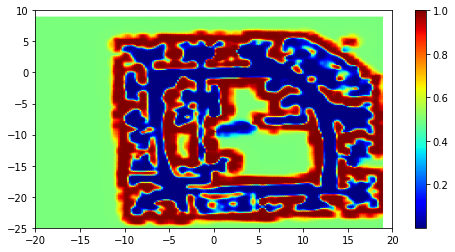

In [16]:
queried = Merge1.predict_proba(q_x)[:,1]
pl.figure(figsize=(8,4))
pl.scatter(q_x[:, 0], q_x[:, 1], c=queried, cmap='jet', s=8, marker='8',edgecolors='')
pl.colorbar()
pl.xlim([cell_max_min[0], cell_max_min[1]]); pl.ylim([cell_max_min[2], cell_max_min[3]])
pl.show()

Distribute the merged maps to each individual agent

In [83]:
LU2_model=copy.deepcopy(Merge1)
RU2_model=copy.deepcopy(Merge1)
LU2_model.coef_=copy.deepcopy(Merge1.coef_)
LU2_model.sigma_=copy.deepcopy(Merge1.sigma_)
RU2_model.coef_=copy.deepcopy(Merge1.coef_)
RU2_model.sigma_=copy.deepcopy(Merge1.sigma_)
LU2_model.mu = copy.deepcopy(Merge1.coef_[0])
LU2_model.Sig_inv =copy.deepcopy(np.diag(np.divide(1,np.diag(Merge1.sigma_[0]))))
RU2_model.mu = copy.deepcopy(LU2_model.mu)
RU2_model.Sig_inv =copy.deepcopy(LU2_model.Sig_inv)
LU2_model.fresh=False
RU2_model.fresh=False

LL2_model=copy.deepcopy(Merge1)
RL2_model=copy.deepcopy(Merge1)
LL2_model.coef_=copy.deepcopy(Merge1.coef_)
LL2_model.sigma_=copy.deepcopy(Merge1.sigma_)
RL2_model.coef_=copy.deepcopy(Merge1.coef_)
RL2_model.sigma_=copy.deepcopy(Merge1.sigma_)
LL2_model.mu = copy.deepcopy(Merge1.coef_[0])
LL2_model.Sig_inv =copy.deepcopy(np.diag(np.divide(1,np.diag(Merge1.sigma_[0]))))
RL2_model.mu = copy.deepcopy(LL2_model.mu)
RL2_model.Sig_inv =copy.deepcopy(LL2_model.Sig_inv)
LL2_model.fresh=False
RL2_model.fresh=False

In [ ]:
#Further training with another batch of the data. This could be done to all the submaps.
max_t = len(np.unique(LUX_1_2[:, 0]))
skip=1
start=0
uniqueList=np.unique(LUX_1_2[:,0])
for ith_scan in range(start, max_t, skip): 
    # extract data points of the ith scan
    ith_scan_indx = LUX_1_2[:, 0] == uniqueList[ith_scan]
    X_new = LUX_1_2[ith_scan_indx, 1:]
    y_new = LUY_1_2[ith_scan_indx]
    
    if ith_scan == start:
        # get all data for the first scan and initialize the model
        X, y = X_new, y_new
    else:
        # information filtering
        q_new = LU2_model.predict_proba(X_new)[:, 1]
        info_val_indx = np.absolute(q_new - y_new) > thresh
        X, y = X_new[info_val_indx, :], y_new[info_val_indx]
        X=X
        y=y
    
    if(X.shape[0]>0):
        LU2_model.fit(X, y)

In [17]:
#Or we can load our pre-trained models. 
#These models have the next batch of the data trained on the first merged map
LU2_model = sbhm.SBHM(gamma=gamma, grid=None, cell_resolution=cell_resolution, cell_max_min=cell_max_min, X=np.array, calc_loss=False, fresh=False)
LU2_model.coef_ = np.load("LU12_coef.npy")
LU2_model.sigma_ = np.array([scipy.sparse.load_npz('LU12_sigma.npz').todense()])

RU2_model = sbhm.SBHM(gamma=gamma, grid=None, cell_resolution=cell_resolution, cell_max_min=cell_max_min, X=np.array, calc_loss=False, fresh=False)
RU2_model.coef_ = np.load("RU12_coef.npy")
RU2_model.sigma_ = np.array([scipy.sparse.load_npz('RU12_sigma.npz').todense()])

LL2_model = sbhm.SBHM(gamma=gamma, grid=None, cell_resolution=cell_resolution, cell_max_min=cell_max_min, X=np.array, calc_loss=False, fresh=False)
LL2_model.coef_ = np.load("LL12_coef.npy")
LL2_model.sigma_ = np.array([scipy.sparse.load_npz('LL12_sigma.npz').todense()])

RL2_model = sbhm.SBHM(gamma=gamma, grid=None, cell_resolution=cell_resolution, cell_max_min=cell_max_min, X=np.array, calc_loss=False, fresh=False)
RL2_model.coef_ = np.load("RL12_coef.npy")
RL2_model.sigma_ = np.array([scipy.sparse.load_npz('RL12_sigma.npz').todense()])


D= 5600
D= 5600
D= 5600
D= 5600


In [19]:
# Overlap 2nd
grandCoef=np.array([LU2_model.coef_[0],RU2_model.coef_[0],LL2_model.coef_[0],RL2_model.coef_[0]])
grandSigma=np.array([LU2_model.sigma_[0].diagonal(),RU2_model.sigma_[0].diagonal(),LL2_model.sigma_[0].diagonal(),RL2_model.sigma_[0].diagonal()])

#Merge Code:
Merge2 = sbhm.SBHM(gamma=gamma, grid=None, cell_resolution=cell_resolution, cell_max_min=cell_max_min, X=np.array, calc_loss=False, fresh=False)
Merge2.coef_ = copy.deepcopy(LU2_model.coef_)
Merge2.sigma_ = copy.deepcopy(LU2_model.sigma_)

hist = copy.deepcopy(Merge1)
overlappingIn=np.zeros(LU2_model.coef_[0].shape)

overlapcount=0
for i in range(0,grandCoef.shape[1]):
    maxMean=grandCoef[0][i]
    minStd=grandSigma[0][i]
    validStd=[]
    validMean=[]
    pastMean=copy.deepcopy(hist.coef_[0][i])
    pastStd=copy.deepcopy(hist.sigma_[0][i,i])
    overlapped=False
    for j in range(0,grandCoef.shape[0]):
        if(grandSigma[j][i]<9900):
            validMean.append(grandCoef[j][i])
            validStd.append(grandSigma[j][i])            
        if(np.abs(maxMean)<np.abs(grandCoef[j][i])):
            maxMean=grandCoef[j][i]
            minStd=min(grandSigma[j][i],minStd)
    
    if(len(validMean)>1):      
        #Here we remove the common information from past values
        for a in range(1,len(validMean)):
            if((abs(pastMean-validMean[a])/(pastMean)>0.00001)or(abs(pastStd-validStd[a])/(pastStd))>0.00001):
                impaststd=validStd[a]
                validStd[a]=abs((pastStd*validStd[a])/(pastStd-validStd[a]))
                validMean[a]=(validMean[a]*(pastStd+validStd[a])-validStd[a]*pastMean)/(pastStd)
        resultantMean_nom=0
        resultantMean_denom=0
        
        resultantStd_denom=0
        if(overlapped==False):
                overlapcount+=1
                overlapped=True
                overlappingIn[i]=1
        for k in range(0,len(validMean)):
            resultantMean_nom+=(validMean[k])/(validStd[k]**2)
            resultantMean_denom+=1/(validStd[k]**2)
            resultantStd_denom+=validStd[k]**(-2)
        Merge2.coef_[0][i]=(resultantMean_nom)/(resultantMean_denom)
        Merge2.sigma_[0][i,i]=(1/(resultantStd_denom))**(0.5)
    else:
        Merge2.coef_[0][i]=maxMean
        Merge2.sigma_[0][i,i]=minStd
print(overlapcount)

D= 5600
3196


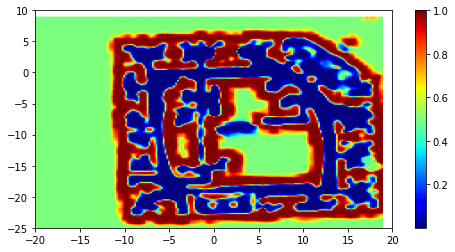

In [87]:
#Visualise merged maps when 50% of all the data has been used
queried = Merge2.predict_proba(q_x)[:,1]
pl.figure(figsize=(8,4))
pl.scatter(q_x[:, 0], q_x[:, 1], c=queried, cmap='jet', s=8, marker='8',edgecolors='')
pl.colorbar()
pl.xlim([cell_max_min[0], cell_max_min[1]]); pl.ylim([cell_max_min[2], cell_max_min[3]])
pl.show()

In [20]:
#Distribute the second merged model to all the agents
LU3_model=copy.deepcopy(Merge2)
RU3_model=copy.deepcopy(Merge2)
LU3_model.coef_=copy.deepcopy(Merge2.coef_)
LU3_model.sigma_=copy.deepcopy(Merge2.sigma_)
RU3_model.coef_=copy.deepcopy(Merge2.coef_)
RU3_model.sigma_=copy.deepcopy(Merge2.sigma_)
LU3_model.mu = copy.deepcopy(Merge2.coef_[0])
LU3_model.Sig_inv =copy.deepcopy(np.diag(np.divide(1,np.diag(Merge2.sigma_[0]))))
RU3_model.mu = copy.deepcopy(LU3_model.mu)
RU3_model.Sig_inv =copy.deepcopy(LU3_model.Sig_inv)
LU3_model.fresh=False
RU3_model.fresh=False

LL3_model=copy.deepcopy(Merge2)
RL3_model=copy.deepcopy(Merge2)
LL3_model.coef_=copy.deepcopy(Merge2.coef_)
LL3_model.sigma_=copy.deepcopy(Merge2.sigma_)
RL3_model.coef_=copy.deepcopy(Merge2.coef_)
RL3_model.sigma_=copy.deepcopy(Merge2.sigma_)
LL3_model.mu = copy.deepcopy(Merge2.coef_[0])
LL3_model.Sig_inv =copy.deepcopy(np.diag(np.divide(1,np.diag(Merge2.sigma_[0]))))
RL3_model.mu = copy.deepcopy(LL3_model.mu)
RL3_model.Sig_inv =copy.deepcopy(LL3_model.Sig_inv)
LL3_model.fresh=False
RL3_model.fresh=False

In [ ]:
#Train the 2nd merged map using the next batch of partitioned data 
max_t = len(np.unique(LUX_2_1[:, 0]))
skip=1
start=0
uniqueList=np.unique(LUX_2_1[:,0])
for ith_scan in range(start, max_t, skip): 
    # extract data points of the ith scan
    ith_scan_indx = LUX_2_1[:, 0] == uniqueList[ith_scan]
    X_new = LUX_2_1[ith_scan_indx, 1:]
    y_new = LUY_2_1[ith_scan_indx]
    
    if ith_scan == start:
        # get all data for the first scan and initialize the model
        X, y = X_new, y_new
    else:
        # information filtering
        q_new = LU3_model.predict_proba(X_new)[:, 1]
        info_val_indx = np.absolute(q_new - y_new) > thresh
        X, y = X_new[info_val_indx, :], y_new[info_val_indx]
        X=X
        y=y
    
    if(X.shape[0]>0):
        LU3_model.fit(X, y)

In [21]:
#Or we can load our pre-trained models. 
#These models have the next batch of the data trained on the second merged map
LU3_model = sbhm.SBHM(gamma=gamma, grid=None, cell_resolution=cell_resolution, cell_max_min=cell_max_min, X=np.array, calc_loss=False, fresh=False)
LU3_model.coef_ = np.load("LU21_coef.npy")
LU3_model.sigma_ = np.array([scipy.sparse.load_npz('LU21_sigma.npz').todense()])

RU3_model = sbhm.SBHM(gamma=gamma, grid=None, cell_resolution=cell_resolution, cell_max_min=cell_max_min, X=np.array, calc_loss=False, fresh=False)
RU3_model.coef_ = np.load("RU21_coef.npy")
RU3_model.sigma_ = np.array([scipy.sparse.load_npz('RU21_sigma.npz').todense()])

LL3_model = sbhm.SBHM(gamma=gamma, grid=None, cell_resolution=cell_resolution, cell_max_min=cell_max_min, X=np.array, calc_loss=False, fresh=False)
LL3_model.coef_ = np.load("LL21_coef.npy")
LL3_model.sigma_ = np.array([scipy.sparse.load_npz('LL21_sigma.npz').todense()])

RL3_model = sbhm.SBHM(gamma=gamma, grid=None, cell_resolution=cell_resolution, cell_max_min=cell_max_min, X=np.array, calc_loss=False, fresh=False)
RL3_model.coef_ = np.load("RL21_coef.npy")
RL3_model.sigma_ = np.array([scipy.sparse.load_npz('RL21_sigma.npz').todense()])


D= 5600
D= 5600
D= 5600
D= 5600


Lets do another merger

In [22]:
# Another merger of the submaps
grandCoef=np.array([LU3_model.coef_[0],RU3_model.coef_[0],LL3_model.coef_[0],RL3_model.coef_[0]])
grandSigma=np.array([LU3_model.sigma_[0].diagonal(),RU3_model.sigma_[0].diagonal(),LL3_model.sigma_[0].diagonal(),RL3_model.sigma_[0].diagonal()])
#Merge Code:
Merge3 = sbhm.SBHM(gamma=gamma, grid=None, cell_resolution=cell_resolution, cell_max_min=cell_max_min, X=np.array, calc_loss=False, fresh=False)
Merge3.coef_ = copy.deepcopy(LU3_model.coef_)
Merge3.sigma_ = copy.deepcopy(LU3_model.sigma_)

hist = copy.deepcopy(Merge2)

overlappingIn=np.zeros(LU3_model.coef_[0].shape)

overlapcount=0
for i in range(0,grandCoef.shape[1]):
    maxMean=grandCoef[0][i]
    minStd=grandSigma[0][i]
    validStd=[]
    validMean=[]
    pastMean=copy.deepcopy(hist.coef_[0][i])
    pastStd=copy.deepcopy(hist.sigma_[0][i,i])
    overlapped=False
    for j in range(0,grandCoef.shape[0]):
        if(grandSigma[j][i]<9900):
            validMean.append(grandCoef[j][i])
            validStd.append(grandSigma[j][i])
            
        if(np.abs(maxMean)<np.abs(grandCoef[j][i])):
            maxMean=grandCoef[j][i]
            minStd=min(grandSigma[j][i],minStd)
    
    if(len(validMean)>1):      
        #Here we remove the common information from past values
        for a in range(1,len(validMean)):
            if((abs(pastMean-validMean[a])/(pastMean)>0.00001)or(abs(pastStd-validStd[a])/(pastStd))>0.00001):
                impaststd=validStd[a]
                validStd[a]=abs((pastStd*validStd[a])/(pastStd-validStd[a]))
                validMean[a]=(validMean[a]*(pastStd+validStd[a])-validStd[a]*pastMean)/(pastStd)
        resultantMean_nom=0
        resultantMean_denom=0
        
        resultantStd_denom=0
        if(overlapped==False):
                overlapcount+=1
                overlapped=True
                overlappingIn[i]=1
        for k in range(0,len(validMean)):
            resultantMean_nom+=(validMean[k])/(validStd[k]**2)
            resultantMean_denom+=1/(validStd[k]**2)
            resultantStd_denom+=validStd[k]**(-2)
        Merge3.coef_[0][i]=(resultantMean_nom)/(resultantMean_denom)
        Merge3.sigma_[0][i,i]=(1/(resultantStd_denom))**(0.5)
    else:
        Merge3.coef_[0][i]=maxMean
        Merge3.sigma_[0][i,i]=minStd
print(overlapcount)

D= 5600
3247


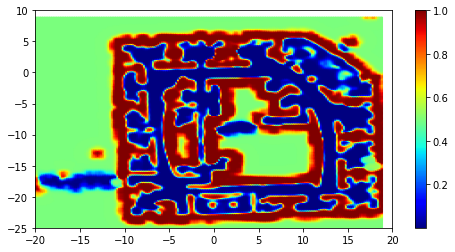

In [97]:
#Visualise merged maps when 75% of all the data has been used
queried = Merge3.predict_proba(q_x)[:,1]
pl.figure(figsize=(8,4))
pl.scatter(q_x[:, 0], q_x[:, 1], c=queried, cmap='jet', s=8, marker='8',edgecolors='')
pl.colorbar()
pl.xlim([cell_max_min[0], cell_max_min[1]]); pl.ylim([cell_max_min[2], cell_max_min[3]])
pl.show()

In [ ]:
#Distribute
LU4_model=copy.deepcopy(Merge3)
RU4_model=copy.deepcopy(Merge3)
LU4_model.coef_=copy.deepcopy(Merge3.coef_)
LU4_model.sigma_=copy.deepcopy(Merge3.sigma_)
RU4_model.coef_=copy.deepcopy(Merge3.coef_)
RU4_model.sigma_=copy.deepcopy(Merge3.sigma_)
LU4_model.mu = copy.deepcopy(Merge3.coef_[0])
LU4_model.Sig_inv =copy.deepcopy(np.diag(np.divide(1,np.diag(Merge3.sigma_[0]))))
RU4_model.mu = copy.deepcopy(LU4_model.mu)
RU4_model.Sig_inv =copy.deepcopy(LU4_model.Sig_inv)
LU4_model.fresh=False
RU4_model.fresh=False

LL4_model=copy.deepcopy(Merge3)
RL4_model=copy.deepcopy(Merge3)
LL4_model.coef_=copy.deepcopy(Merge3.coef_)
LL4_model.sigma_=copy.deepcopy(Merge3.sigma_)
RL4_model.coef_=copy.deepcopy(Merge3.coef_)
RL4_model.sigma_=copy.deepcopy(Merge3.sigma_)
LL4_model.mu = copy.deepcopy(Merge3.coef_[0])
LL4_model.Sig_inv =copy.deepcopy(np.diag(np.divide(1,np.diag(Merge3.sigma_[0]))))
RL4_model.mu = copy.deepcopy(LU4_model.mu)
RL4_model.Sig_inv =copy.deepcopy(LU4_model.Sig_inv)
LL4_model.fresh=False
RL4_model.fresh=False


In [ ]:
#Train 4th round (I should really write a function instead)
#This trains the merged map for one agent on the next batch of data.
#Repeat on every agent to get submaps from all the agents
max_t = len(np.unique(LUX_2_2[:, 0]))
skip=1
start=0
uniqueList=np.unique(LUX_2_2[:,0])
for ith_scan in range(start, max_t, skip): 
    # extract data points of the ith scan
    ith_scan_indx = LUX_2_2[:, 0] == uniqueList[ith_scan]
    X_new = LUX_2_2[ith_scan_indx, 1:]
    y_new = LUY_2_2[ith_scan_indx]
    
    if ith_scan == start:
        # get all data for the first scan and initialize the model
        X, y = X_new, y_new
    else:
        # information filtering
        q_new = LU4_model.predict_proba(X_new)[:, 1]
        info_val_indx = np.absolute(q_new - y_new) > thresh
        X, y = X_new[info_val_indx, :], y_new[info_val_indx]
        X=X
        y=y
    
    if(X.shape[0]>0):
        LU4_model.fit(X, y)

In [95]:
#Or we can load our pre-trained models. 
#These models have the next batch of the data trained on the third merged map
LU4_model = sbhm.SBHM(gamma=gamma, grid=None, cell_resolution=cell_resolution, cell_max_min=cell_max_min, X=np.array, calc_loss=False, fresh=False)
LU4_model.coef_ = np.load("LU22_coef.npy")
LU4_model.sigma_ = np.array([scipy.sparse.load_npz('LU22_sigma.npz').todense()])

RU4_model = sbhm.SBHM(gamma=gamma, grid=None, cell_resolution=cell_resolution, cell_max_min=cell_max_min, X=np.array, calc_loss=False, fresh=False)
RU4_model.coef_ = np.load("RU22_coef.npy")
RU4_model.sigma_ = np.array([scipy.sparse.load_npz('RU22_sigma.npz').todense()])

LL4_model = sbhm.SBHM(gamma=gamma, grid=None, cell_resolution=cell_resolution, cell_max_min=cell_max_min, X=np.array, calc_loss=False, fresh=False)
LL4_model.coef_ = np.load("LL22_coef.npy")
LL4_model.sigma_ = np.array([scipy.sparse.load_npz('LL22_sigma.npz').todense()])

RL4_model = sbhm.SBHM(gamma=gamma, grid=None, cell_resolution=cell_resolution, cell_max_min=cell_max_min, X=np.array, calc_loss=False, fresh=False)
RL4_model.coef_ = np.load("RL22_coef.npy")
RL4_model.sigma_ = np.array([scipy.sparse.load_npz('RL22_sigma.npz').todense()])

D= 5600
D= 5600
D= 5600
D= 5600


In [96]:
# Another merger of the submaps
grandCoef = np.array([LU4_model.coef_[0],RU4_model.coef_[0],LL4_model.coef_[0],RL4_model.coef_[0]])
grandSigma = np.array([LU4_model.sigma_[0].diagonal(),RU4_model.sigma_[0].diagonal(),LL4_model.sigma_[0].diagonal(),RL4_model.sigma_[0].diagonal()])
#Merge Code:
Merge4 = sbhm.SBHM(gamma=gamma, grid=None, cell_resolution=cell_resolution, cell_max_min=cell_max_min, X=np.array, calc_loss=False, fresh=False)
Merge4.coef_ = copy.deepcopy(LU3_model.coef_)
Merge4.sigma_ = copy.deepcopy(LU3_model.sigma_)

hist = copy.deepcopy(Merge3)

overlappingIn=np.zeros(LU4_model.coef_[0].shape)

overlapcount=0
for i in range(0,grandCoef.shape[1]):
    maxMean = grandCoef[0][i]
    minStd = grandSigma[0][i]
    validStd = []
    validMean = []
    pastMean = copy.deepcopy(hist.coef_[0][i])
    pastStd = copy.deepcopy(hist.sigma_[0][i,i])
    overlapped = False
    for j in range(0,grandCoef.shape[0]):
        if(grandSigma[j][i]<9900):
            validMean.append(grandCoef[j][i])
            validStd.append(grandSigma[j][i])
            
        if(np.abs(maxMean)<np.abs(grandCoef[j][i])):
            maxMean = grandCoef[j][i]
            minStd = min(grandSigma[j][i],minStd)
    
    if(len(validMean)>1):      
        #Here we remove the common information from past values
        for a in range(1,len(validMean)):
            if((abs(pastMean-validMean[a])/(pastMean)>0.00001)or(abs(pastStd-validStd[a])/(pastStd))>0.00001):
                impaststd=validStd[a]
                validStd[a]=abs((pastStd*validStd[a])/(pastStd-validStd[a]))
                validMean[a]=(validMean[a]*(pastStd+validStd[a])-validStd[a]*pastMean)/(pastStd)
        resultantMean_nom=0
        resultantMean_denom=0
        
        resultantStd_denom=0
        if(overlapped==False):
                overlapcount+=1
                overlapped=True
                overlappingIn[i]=1
        for k in range(0,len(validMean)):
            resultantMean_nom+=(validMean[k])/(validStd[k]**2)
            resultantMean_denom+=1/(validStd[k]**2)
            resultantStd_denom+=validStd[k]**(-2)
        Merge4.coef_[0][i]=(resultantMean_nom)/(resultantMean_denom)
        Merge4.sigma_[0][i,i]=(1/(resultantStd_denom))**(0.5)
    else:
        Merge4.coef_[0][i]=maxMean
        Merge4.sigma_[0][i,i]=minStd
print(overlapcount)

D= 5600
3372


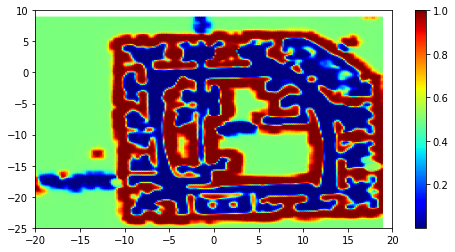

In [98]:
#Visualise merged maps when all the batches of data have been used
queried = Merge4.predict_proba(q_x)[:,1]
pl.figure(figsize=(8,4))
pl.scatter(q_x[:, 0], q_x[:, 1], c=queried, cmap='jet', s=8, marker='8',edgecolors='')
pl.colorbar()
pl.xlim([cell_max_min[0], cell_max_min[1]]); pl.ylim([cell_max_min[2], cell_max_min[3]])
pl.show()

This is the merged map when all the data from the batches have been used